In [1]:
import sys, os
if os.path.abspath(os.pardir) not in sys.path:
    sys.path.insert(0, os.path.abspath(os.pardir))
import CONFIG
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import torch
import pydicom
import matplotlib.pyplot as plt

In [81]:
DATA_DIR = CONFIG.CFG.DATA.BASE
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# number of slices used to create a single 3D array of the scan
NUM_SLICES = 8

In [82]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

In [83]:
TRAIN_PATIENTS = train_df['Patient'].unique().tolist()
TEST_PATIENTS = test_df['Patient'].unique().tolist()

In [84]:
path = os.path.join(DATA_DIR, "train", TRAIN_PATIENTS[4])
slices = [pydicom.read_file(os.path.join(path, s)) for s in os.listdir(path)]
slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

In [85]:
len(slices)

49

In [86]:
# the preprocessed array with NUM_SLICES elements
# TODO: Handle the case when the NUM_SLICES > the actual total slices
# TODO: resize the image to 256 X 256?
out_array = []

remainder_array_size = len(slices)%NUM_SLICES
avging_array_size = len(slices)//NUM_SLICES

# get the first array with the remainder
first_array = []
first_avging_slices = slices[:remainder_array_size+avging_array_size]
for slice in first_avging_slices:
    first_array.append(slice.pixel_array)
first_avged_array = np.average(first_array, axis=0)
out_array.append(first_avged_array)
# now get the remaining averaged N-1 arrays and append to out_array so that the size is NUM_SLICES * image_size

In [87]:
for i in range(remainder_array_size + avging_array_size, len(slices), avging_array_size):
    temp_array = []
    for slice in slices[i:i+avging_array_size]:
        temp_array.append(slice.pixel_array)
    avged_temp_array = np.average(temp_array, axis=0)
    out_array.append(avged_temp_array)

In [88]:
out_array = np.array(out_array)
out_array.shape

(8, 512, 512)

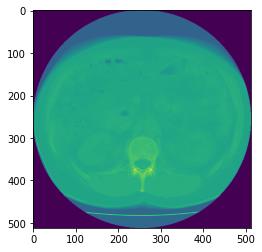

In [70]:
plt.imshow(first_avged_array)

In [ ]:
slices_array = []
for slice in slices[:9]:
    slices_array.append(slice.pixel_array)
slices_array = np.array(slices_array)

In [31]:
averaged_array = np.average(slices_array, axis=1)

In [33]:
averaged_array.shape

(9, 512)

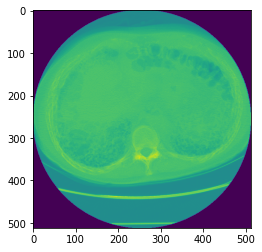

In [30]:
plt.imshow(averaged_array)
plt.show()

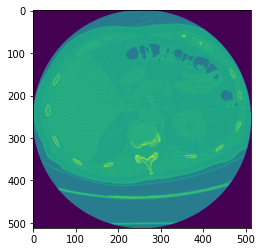

In [9]:
plt.imshow(slices[0].pixel_array)
plt.show()

In [10]:
least = float('inf')
for id in TEST_PATIENTS:
    if len(os.listdir(os.path.join(DATA_DIR, "test", id))) < least:
        least = len(os.listdir(os.path.join(DATA_DIR, "test", id)))

print(least)

28
